In [17]:
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
from pylab import rcParams
import datetime
from dateutil.relativedelta import *
import numpy as np

Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

In [2]:
df = pd.read_csv('WAG_C_M.csv', sep=';')
df.head()

,month,WAG_C_M
0,01.01.1993,15.3
1,01.02.1993,19.1
2,01.03.1993,23.6
3,01.04.1993,30.6
4,01.05.1993,37.5


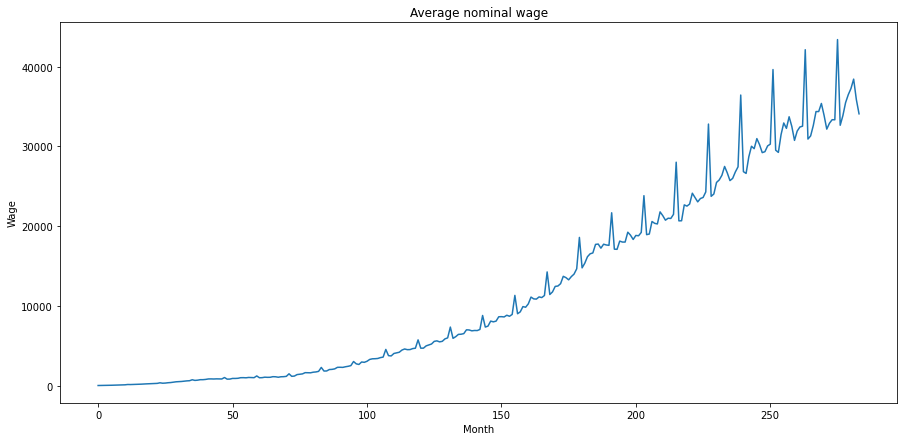

In [3]:
plt.figure(figsize=(15,7))
df.WAG_C_M.plot()
plt.title('Average nominal wage')
plt.ylabel('Wage')
plt.xlabel('Month')
plt.show()

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

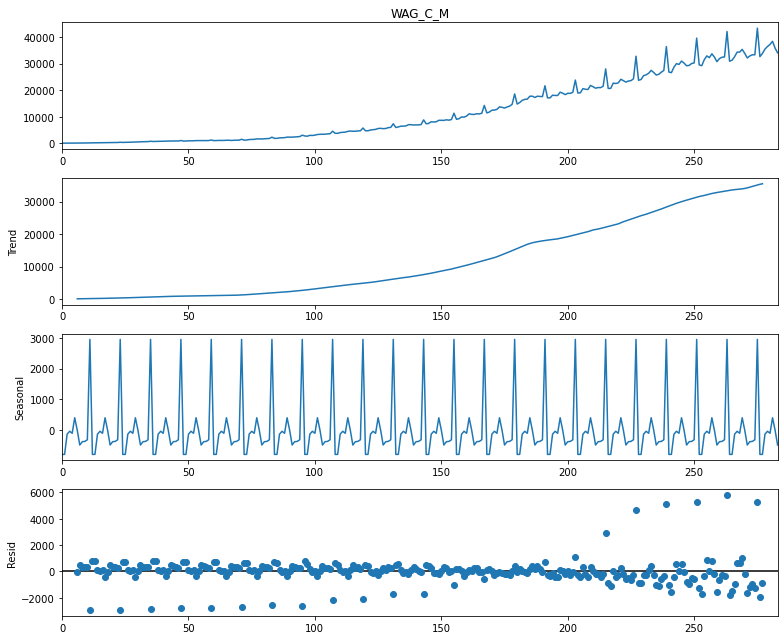

In [4]:
rcParams['figure.figsize'] = 11, 9

df['month'] = pd.to_datetime(df['month'])

plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(df.WAG_C_M, period=12).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.WAG_C_M)[1])

**Стабилизация дисперсии**

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.991850


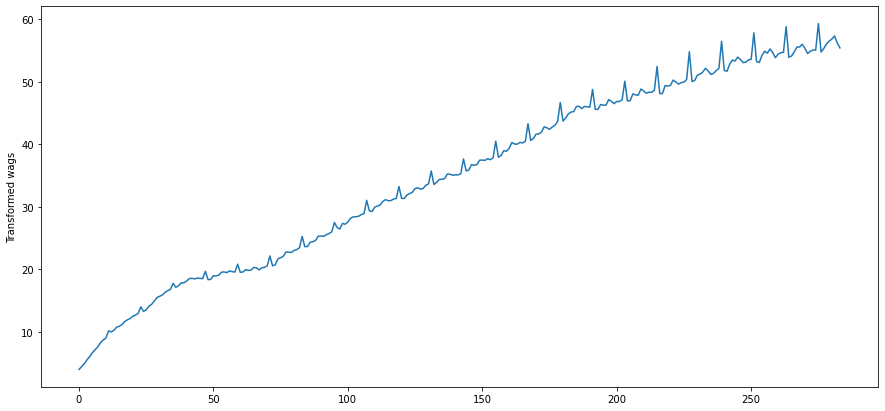

In [5]:
df['wag_box'], lmbda = stats.boxcox(df.WAG_C_M)
plt.figure(figsize=(15,7))
df.wag_box.plot()
plt.ylabel(u'Transformed wags')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.WAG_C_M)[1])

#### Стационарность
Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

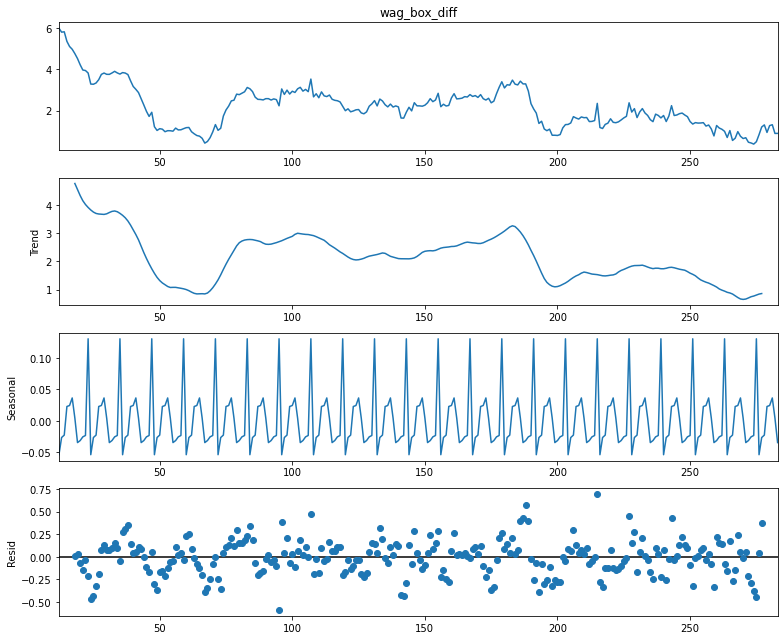

In [6]:
df['wag_box_diff'] = df.wag_box - df.wag_box.shift(12)
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(df.wag_box_diff[12:], period=12).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.wag_box_diff[12:])[1])

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

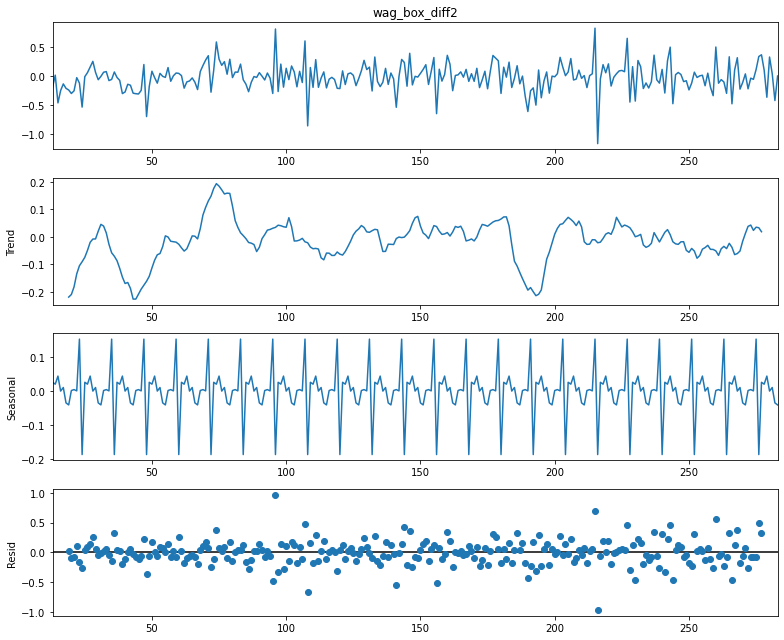

In [7]:
df['wag_box_diff2'] = df.wag_box_diff - df.wag_box_diff.shift(1)
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(df.wag_box_diff2[13:], period=12).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.wag_box_diff2[13:])[1])

#### Подбор модели
Посмотрим на ACF и PACF полученного ряда

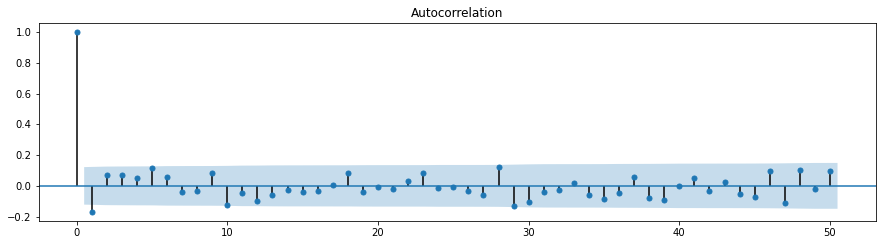

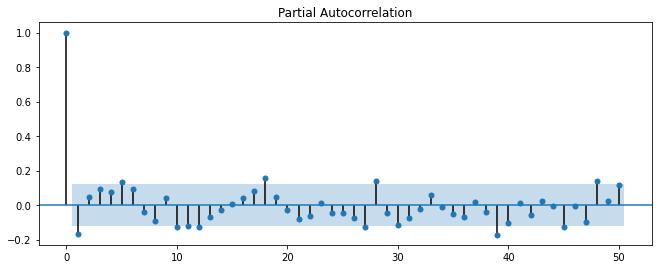

In [8]:
plt.figure(figsize=(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.wag_box_diff2.dropna()[13:].values.squeeze(), lags=50, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.wag_box_diff2.dropna()[13:].values.squeeze(), lags=50, ax=ax)
plt.show()

Начальные приближения: Q=0, q=1, P=1, p=1.

In [9]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 1)

In [10]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

8

In [11]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df.wag_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 1.08 s


In [12]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters       aic
5  (1, 0, 1, 0)  0.340521
3  (0, 1, 1, 0)  1.170768
7  (1, 1, 1, 0)  2.021911
4  (1, 0, 0, 0)  2.625709
2  (0, 1, 0, 0)  3.369832


Лучшая модель:

In [13]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            wag_box   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Sun, 18 Oct 2020   AIC                              0.341
Time:                                    11:52:14   BIC                             11.147
Sample:                                         0   HQIC                             4.679
                                            - 284                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1488      0.046     -3.211      0.001      -0.240      -0.058
ar.S.L12      -0.1314      0.046   

Критерий Стьюдента: p=0.090790
Критерий Дики-Фуллера: p=0.000003


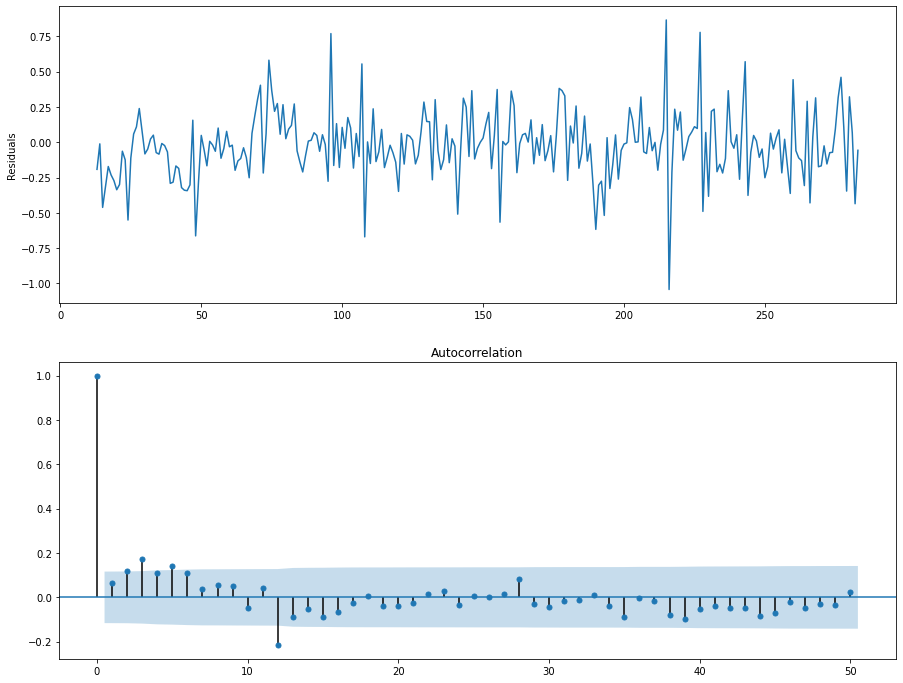

In [14]:
plt.figure(figsize=(15,12))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=50, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента), стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:|

Text(0.5, 1.0, 'Average nominal wage')

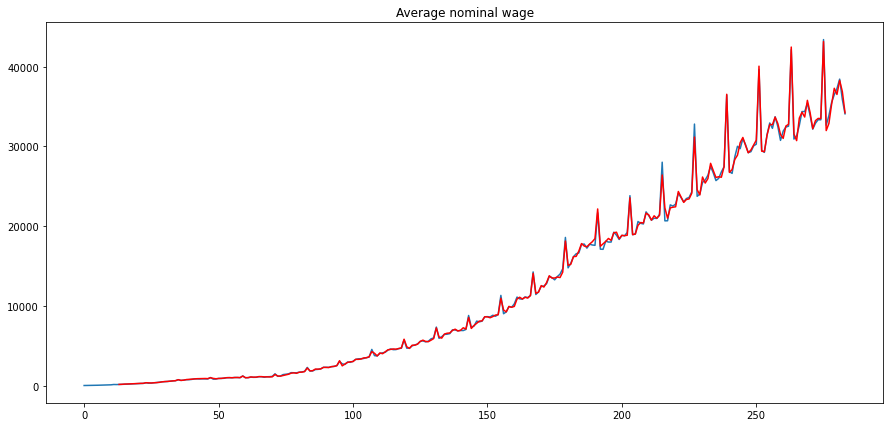

In [18]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

df['model'] = invboxcox(best_model.fittedvalues, lmbda)

plt.figure(figsize=(15,7))
df.WAG_C_M.plot()
df.model[13:].plot(color='r')
plt.title('Average nominal wage')

#### Прогноз

Text(0.5, 1.0, 'Average nominal wage')

<Figure size 1080x504 with 0 Axes>

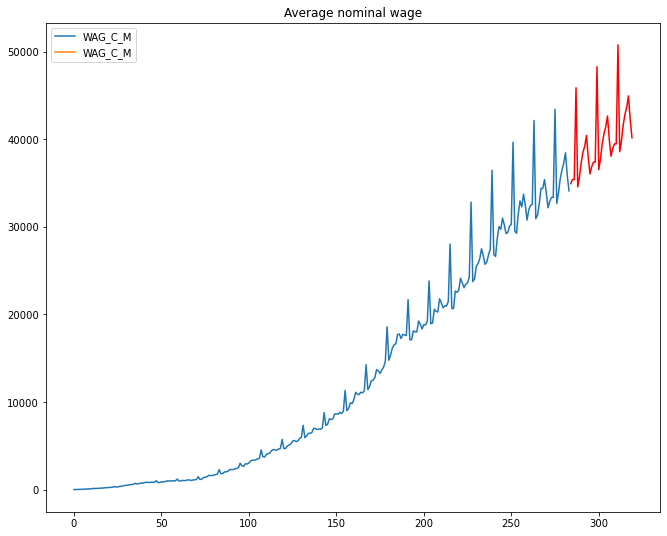

In [19]:
date_list = [x for x in range(284, 320)]
future = pd.DataFrame(index=date_list, columns=df[['WAG_C_M']].columns)
wage = pd.concat([df[['WAG_C_M']], future], axis=1)
wage['forecast'] = invboxcox(best_model.predict(start=284, end=319), lmbda)

plt.figure(figsize=(15,7))
wage.WAG_C_M.plot()
wage.forecast.plot(color='r')
plt.title('Average nominal wage')